# Librerías

In [ ]:
import pandas as pd
import numpy as np

# Text preprocessing
import string
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Librerias para visualización
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Tensorflow y keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Conjunto de datos

In [ ]:
# Ejecutar las siguientes líneas para descargar el conjunto de datos y descomprimirlo
!gdown 18Z7p4VYyPZGEvYdmBgBGSSMXYSfIT-4-
!unzip Covid_Tweets.zip

Downloading...
From: https://drive.google.com/uc?id=18Z7p4VYyPZGEvYdmBgBGSSMXYSfIT-4-
To: /content/Covid_Tweets.zip
100% 3.97M/3.97M [00:00<00:00, 122MB/s]
Archive:  Covid_Tweets.zip
  inflating: Covid_Tweets_test.csv   
  inflating: Covid_Tweets_train.csv  


Utilizaremos un conjunto de datos de tweets sobre COVID-19 que contiene información sobre el texto del tweet (tweet original) y el sentimiento (positivo, negativo, neutro). Se puede acceder al conjunto de datos a través de los archivos .csv proporcionados. Data de entrenamiento se encuentra en el archivo ``Covid_Tweets_train.csv`` y data de prueba en el archivo ``Covid_Tweets_test.csv``

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar el conjunto de datos de entrenamiento
file_path = '/content/Covid_Tweets_train.csv'

# Mostrar algunos registros
train_data = pd.read_csv(file_path)
print(train_data.head())


                                       OriginalTweet Sentiment
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   Neutral
1  advice Talk to your neighbours family to excha...  Positive
2  Coronavirus Australia: Woolworths to give elde...  Positive
3  My food stock is not the only one which is emp...  Positive
4  Me, ready to go at supermarket during the #COV...  Negative


In [ ]:
type(train_data)

pandas.core.frame.DataFrame

# Análisis de datos



## Información de las variables

Mostrar información de las variables incluyendo tipo de datos, cantidad de registros, datos faltantes o duplicados

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


## Distribución de clases

Mostrar visualmente y numéricamente la distribución de clases del conjunto de datos

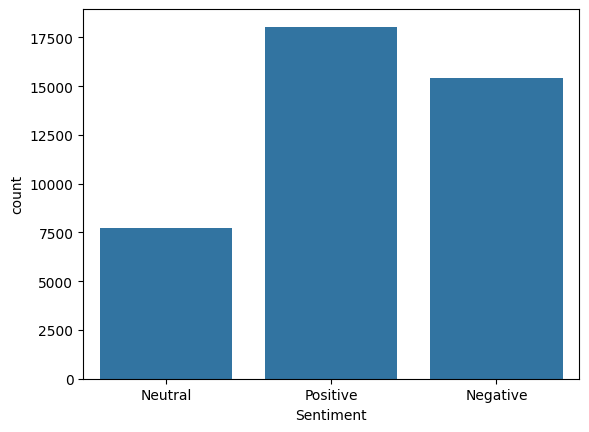

In [ ]:
# Mostrar la distribución de clases. Puede usar countplot o bar plo
sns.countplot(x='Sentiment', data=train_data)
plt.show()


In [ ]:
# Mostrar la cantidad de muestras por clase
train_data['Sentiment'].value_counts()


,count
Sentiment,
Positive,18046
Negative,15398
Neutral,7713


## Tweets de ejemplo

Muestre algunos tweets e identifique que partes del contenido se podrían limpiar

In [ ]:
random_records = train_data.sample(n=3)
print(random_records)

                                           OriginalTweet Sentiment
3701   IMPORTANT UPDATE: ?\r\r\n\r\r\nYou can still r...  Positive
37825  Please note we ve stock food in our refrigerat...  Positive
39296  Artisanal Gold Council has begun an artisanal ...  Positive


# Limpieza de datos

La siguiente función realiza una limpieza inicial de los textos. Revisela y de ser posible aumente otras formas de limpiar el texto

In [ ]:
stop_words = set(stopwords.words('english')) # Las stopwords son palabras vacias como 'i', 'me', 'my', 'we'....

def limpiar_tweet(tweet): # Usa expresiones regulares
    tweet = tweet.lower()                               # Convertir texto a minúsculas
    tweet = re.sub('https?://\S+', '', tweet)           # Remover URLs
    tweet = re.sub(r'@\w+|#\w+', '', tweet)             # Remover menciones y hashtags
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)           # Remover caracteres especiales y números
    tweet = re.sub("\s\s+" , " ", tweet)                # Remover multiples espacios

    # Remover stopwords
    tokens = tweet.split()
    tweet_limpio = [token for token in tokens if token not in stop_words]
    return ' '.join(tweet_limpio) # Concatena las palabras en una oracion limpia

Probemos el método de limpieza

In [ ]:
tercera_linea = train_data.iloc[0]['OriginalTweet']
print(tercera_linea)

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8


In [ ]:
tweet = train_data.iloc[2]['OriginalTweet']
tweet_limpio = limpiar_tweet(tweet)

print(f'Original: {tweet}')
print(f'\nLimpio: {tweet_limpio}')

Original: Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P

Limpio: coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak


Aplicar el método de limpieza a todos los tweets

In [ ]:
# Limpiar todos los tweets dados en el dataset y asignar el resultado a una
# nueva columna en el dataframe
train_data["CleanTweet"] = train_data["OriginalTweet"].apply(limpiar_tweet)


Mostrar al menos 5 tweets sin limpiar y luego de aplicar la limpieza

In [ ]:
# Mostrar algunos tweets antes y luego de la limpieza
print("Tweets originales:")
print(train_data["OriginalTweet"].head())
print("\nTweets limpios:")
print(train_data["CleanTweet"].head())

Tweets originales:
0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: OriginalTweet, dtype: object

Tweets limpios:
0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please dont panic enough ...
4    ready go supermarket outbreak im paranoid food...
Name: CleanTweet, dtype: object


## Distribución del número de tokens

Se obtiene la cantidad de tokens de cada tweet

In [ ]:
num_tokens = [len(tweet.split()) for tweet in train_data['CleanTweet']]

In [ ]:
num_tokens

[0,
 27,
 12,
 16,
 17,
 25,
 14,
 6,
 24,
 21,
 17,
 21,
 21,
 10,
 17,
 12,
 0,
 14,
 26,
 17,
 25,
 15,
 8,
 9,
 19,
 19,
 17,
 22,
 21,
 16,
 9,
 11,
 6,
 11,
 20,
 9,
 25,
 14,
 27,
 5,
 12,
 19,
 11,
 13,
 7,
 9,
 22,
 16,
 7,
 20,
 21,
 9,
 22,
 24,
 25,
 5,
 21,
 25,
 20,
 5,
 5,
 12,
 13,
 19,
 9,
 10,
 18,
 14,
 14,
 17,
 27,
 6,
 8,
 27,
 23,
 22,
 21,
 13,
 14,
 19,
 15,
 23,
 22,
 11,
 16,
 30,
 18,
 14,
 23,
 23,
 21,
 16,
 17,
 25,
 21,
 28,
 22,
 23,
 12,
 25,
 13,
 18,
 16,
 25,
 33,
 13,
 14,
 8,
 6,
 23,
 17,
 17,
 16,
 9,
 27,
 21,
 14,
 23,
 24,
 17,
 14,
 18,
 11,
 20,
 24,
 20,
 21,
 12,
 14,
 3,
 29,
 24,
 26,
 19,
 23,
 11,
 26,
 21,
 27,
 4,
 18,
 17,
 22,
 5,
 17,
 29,
 16,
 25,
 2,
 12,
 17,
 11,
 19,
 26,
 14,
 3,
 15,
 4,
 21,
 17,
 17,
 20,
 29,
 18,
 22,
 15,
 15,
 30,
 12,
 20,
 28,
 23,
 30,
 25,
 6,
 8,
 23,
 13,
 24,
 5,
 12,
 12,
 6,
 12,
 21,
 23,
 0,
 26,
 11,
 12,
 11,
 28,
 26,
 28,
 13,
 17,
 21,
 12,
 21,
 22,
 21,
 18,
 30,
 12,
 25,
 20,
 14

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
 2   CleanTweet     41157 non-null  object
dtypes: object(3)
memory usage: 964.7+ KB


Mostrar un histograma de la cantidad de tokens

In [ ]:
# Crear un dataframe con el número de tokens por tweet y muestre algunas estadísticas (puede usar .describe())
df = pd.DataFrame({'num_tokens': num_tokens,"Cleantweet": train_data['CleanTweet'],"Sentiment": train_data['Sentiment']})
df.head()


,num_tokens,Cleantweet,Sentiment
0,0,,Neutral
1,27,advice talk neighbours family exchange phone n...,Positive
2,12,coronavirus australia woolworths give elderly ...,Positive
3,16,food stock one empty please dont panic enough ...,Positive
4,17,ready go supermarket outbreak im paranoid food...,Negative


In [ ]:
# Crear un histograma usando la cantidad de tokens de cada tweet
#hist= set(num_tokens)
#hist #40

df_agrupado = df.groupby('num_tokens').count()
print(df_agrupado)

            Cleantweet  Sentiment
num_tokens                       
0                   51         51
1                  115        115
2                  349        349
3                  584        584
4                  764        764
5                 1081       1081
6                 1272       1272
7                 1532       1532
8                 1715       1715
9                 1761       1761
10                1716       1716
11                1743       1743
12                1817       1817
13                1781       1781
14                1769       1769
15                1832       1832
16                1835       1835
17                1991       1991
18                2049       2049
19                2066       2066
20                2094       2094
21                2059       2059
22                1900       1900
23                1741       1741
24                1466       1466
25                1256       1256
26                 903        903
27            

En caso de que se tengan tweets con pocos tokens o ninguno entonces puede eliminarlos de la data

In [ ]:
# Eliminar filas de la data de entrenamiento que contengan pocos o ningún token después de realizar la limpieza

df_filtrado = df.query('num_tokens not in [0, 1]')
len(df_filtrado) # eliminó 166 tweets



40991

En caso de haber eliminado algunas filas, vuelva a mostrar la distribución de tokens

In [ ]:
print(df_filtrado.groupby('num_tokens').count())

            Cleantweet  Sentiment
num_tokens                       
2                  349        349
3                  584        584
4                  764        764
5                 1081       1081
6                 1272       1272
7                 1532       1532
8                 1715       1715
9                 1761       1761
10                1716       1716
11                1743       1743
12                1817       1817
13                1781       1781
14                1769       1769
15                1832       1832
16                1835       1835
17                1991       1991
18                2049       2049
19                2066       2066
20                2094       2094
21                2059       2059
22                1900       1900
23                1741       1741
24                1466       1466
25                1256       1256
26                 903        903
27                 689        689
28                 461        461
29            

## Convertir etiquetas a números

In [ ]:
# Reemplace las etiquetas (sentimientos) a números, considerar lo siguiente:
# - Negative = 0, Neutral = 1, Positive = 2


In [ ]:
mapeo_etiquetas = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df_filtrado['Sentiment'] = df_filtrado['Sentiment'].replace(mapeo_etiquetas)

<ipython-input-23-a1f2036b6e6c>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtrado['Sentiment'] = df_filtrado['Sentiment'].replace(mapeo_etiquetas)
<ipython-input-23-a1f2036b6e6c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Sentiment'] = df_filtrado['Sentiment'].replace(mapeo_etiquetas)


# Particionamiento de datos

In [ ]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40991 entries, 1 to 41156
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   num_tokens  40991 non-null  int64 
 1   Cleantweet  40991 non-null  object
 2   Sentiment   40991 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


Realice el particionamiento de datos en entrenamiento y validación. Mostrar los tamaños luego de particionar la data

In [ ]:
train_df, val_df  = train_test_split(df_filtrado, test_size=0.2, random_state=42)

In [ ]:
print(len(train_df))
print(len(val_df))

32792
8199


Obtenemos las etiquetas de ambos conjuntos de datos

In [ ]:
y_train = train_df['Sentiment'].values
y_val = val_df['Sentiment'].values

# Preprocesamiento

## Vectorización de textos a indices incluyendo padding

Usar ``TextVectorization`` para preprocesar los tweets limpios. Para ello debe convertir la data de entrenamiento a índices

In [ ]:
# Definir un tamaño de vocabulario
vocab_size = len(vocabulario)

vocabulario = set()
for tweet in train_df['Cleantweet']:
    for word in tweet.split():
        vocabulario.add(word.lower())
print("Vocabulario:", vocabulario)

print(f'{len(vocabulario)} palabras únicas')
vocab_size = len(vocabulario)

Vocabulario: {'needtoeat', 'nominal', 'queue', 'wealthy', 'sd', 'sixfoot', 'dif', 'modified', 'voila', 'racers', 'maniac', 'sleepover', 'combination', 'wago', 'shibley', 'soybean', 'underwent', 'fighter', 'paranaque', 'biel', 'elisabeth', 'triest', 'barrio', 'clsu', 'connectivity', 'manager', 'stuff', 'audition', 'kmt', 'boschetto', 'notley', 'slightly', 'amphiphiles', 'zajistil', 'covidaffected', 'zoning', 'heel', 'quarantinegonna', 'pkp', 'flourishes', 'alessandro', 'der', 'effing', 'crowdsource', 'silently', 'feck', 'worsens', 'gratefully', 'fathers', 'operators', 'martin', 'distrbtn', 'marketing', 'dickinson', 'fledged', 'appalled', 'detroit', 'siege', 'drying', 'pakistans', 'luis', 'miracle', 'canceled', 'leaned', 'tinned', 'kitted', 'inventories', 'hizmeti', 'jk', 'cds', 'dilutes', 'trojan', 'expatriates', 'realize', 'lovely', 'healers', 'snide', 'foodmedicinesbasic', 'profs', 'overwing', 'galitsky', 'thoughtfully', 'teamed', 'tagged', 'coating', 'monroe', 'matzah', 'visually', '

In [ ]:
# Definir el máximo tamaño de secuencia para cada tweet.
# Tome en cuenta la distribución de tokens calculada anteriormente
max_seq_len = 40

# - Crear capa de vectorización de textos (TextVectorization)
# - Especifique valores para max_tokens, output_mode y output_sequence_length
# - Recuerde que para cada tweet limpio se espera como resultado una lista
# de identificadores (números) con padding dependiendo del máximo tamaño
# de secuencia especificado
vectorizer = tf.keras.layers.TextVectorization(output_mode="int",
                                               output_sequence_length = max_seq_len )

# Adaptar vectorizador a los tweets limpios de entrenamiento
vectorizer.adapt(train_df['Cleantweet'].values)

# Transformar tweets de entrenamiento y validación
X_train_pad = vectorizer(train_df['Cleantweet'].values)
X_val_pad = vectorizer(val_df['Cleantweet'].values)

print(f'Tamaño de la data de entrenamiento: ', {X_train_pad.shape})
print(f'Tamaño de la data de prueba: ', {X_val_pad.shape})
print(f'Muestra de entrenamiento: {X_train_pad[0]}')

Tamaño de la data de entrenamiento:  {TensorShape([32792, 40])}
Tamaño de la data de prueba:  {TensorShape([8199, 40])}
Muestra de entrenamiento: [3014 3878    2   10  939 1375 3452 2864   67  453    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
len(X_train_pad)

32792

Ejemplo de salida (no es necesario que su salida sea exactamente la misma pero debe de tener un formato similar):
```
Tamaño de la data de entrenamiento:  {TensorShape([32513, 40])}
Tamaño de la data de prueba:  {TensorShape([8129, 40])}
Muestra de entrenamiento: [ 819    1  103 4569  240    1    8   18   35 1299    4 1487   13  248
   13 1121    1    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
```

Luego de aplicar la transformación, todos los vectores de entrenamiento y validación deben de tener el mismo tamaño, con ceros al final en algunos casos (padding).

# Modelo


## Creación de modelo usando RNNs

Completar la siguiente función con las siguientes capas:
- Capa de entrada que acepta tamaños iguales al máximo tamaño de secuencia (``max_seq_len``)
- Capa de embedding que hace uso de ``vocab_size`` y ``embed_size``. Especificar el valor de ``mask_zero=True`` para omitir padding
- Capa de dropout
- Capa LSTM con ``rnn_units`` y dropout. No es necesario cambiar otros hiperparámetros. Recuerde que clasificación es un problema de muchos a uno
- Capa densa con ``output_size`` unidades y función de activación

In [ ]:
def crear_rnn(max_seq_len, vocab_size, embed_size, output_size, rnn_units, dropout=0.5):
    modelo_rnn = Sequential([
        # Capa de entrada que acepta tamaños iguales al máximo tamaño de secuencia (max_seq_len)

        # Capa de embedding que hace uso de vocab_size y embed_size. Especificar el valor de mask_zero=True para omitir padding
        tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True) #[vocab_size, embed_size] -- W

        # Capa de dropout

        # Capa LSTM con rnn_units y dropout

        # Capa densa con output_size unidades y función de activación

    ])
    return modelo_rnn

Crear el modelo usando la función anterior y mostrar detalles de la arquitectura (summary)

In [ ]:
modelo_rnn =

## Entrenamiento

Realice el entrenamiento del modelo. Pruebe diferentes valores de los hiperparámetros y aplique las técnicas aprendidas hasta el momento para obtener el mejor modelo usando la data de entrenamiento y validación

In [ ]:
# Callbacks


# Hiperparámetros
learning_rate =
epocas =
batch_size =
embed_size =
num_classes =
rnn_units =
dropout =

# Crear modelo
modelo_rnn =

# Compilar el modelo


# Entrenar el modelo
output_rnn =

## Curvas de aprendizaje

Mostrar la curva de aprendizaje con el error de entrenamiento y validación

## Predicciones

Usando el mejor modelo obtenido durante el entrenamiento, realie predicciones para entrenamiento y validación

In [ ]:
# Obtener probabilidades de entrenamiento
probabilidades_train =

# Obtener probabilidades de validación
probabilidades_val =

In [ ]:
# Convertir las probabilidades a predicciones
y_train_pred =
y_val_pred =

### Reporte de clasificación

Muestre el reporte de clasificación (``classification_report``) para la data de entrenamiento

Muestre el reporte de clasificación (``classification_report``) para la data de validación

# Data de prueba

### Cargar datos

In [ ]:
# Cargar la data de prueba (Covid_Tweets_test.csv)
test_df =

### Limpieza de tweets

Realice la limpieza de los tweets de prueba. Puede usar las funciones antes implementadas. Recuerde que debe realizar el mismo proceso de limpieza que el usado en la data de entrenamiento

In [ ]:
# Limpiar todos los tweets dados en el dataset y asignar el resultado a una
# nueva columna en el dataframe
test_df["CleanTweet"] =


# Mostrar algunos tweets antes y luego de la limpieza


In [ ]:
# Reemplace las etiquetas (sentimientos) a números, considerar lo siguiente:
# - Negative = 0, Neutral = 1, Positive = 2


# Separe las etiquetas
y_test =

# Preprocesar los tweets limpios de prueba usando el vectorizador de textos
# adaptado durante el entrenamiento
X_test_pad =

### Predicciones

In [ ]:
# Obtener probabilidades de la data de prueba
probabilidades_test =

# Convertir las probabilidades a predicciones
y_test_pred =

### Reporte de clasificación

Muestre el reporte de clasificación (``classification_report``) para la data de prueba

### Matriz de confusión

Muestre la matriz de confusión de la data de prueba